# Persistence Homology Transform

In [1]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy import stats
import scipy
from scipy.sparse import csr_matrix

In [2]:
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot
from vineyard import *
%load_ext autoreload
%autoreload 2

In [3]:
import multiprocess as mp

In [4]:
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

In [5]:
def rand_seed():
    return int(np.random.rand()*1e5)

In [6]:
def direction_filtration(pts, direction, dim=0, eps=0.0, out="barcode", one_cycle=False):
    n = pts.shape[0]
    hs = pts[:, 0] * direction[0] + pts[:, 1] * direction[1] # dot product
 
    st = gudhi.SimplexTree()
    for i in range(n):
        st.insert([i], hs[i])
    for i in range(n):
        st.insert([i, (i + 1)%n], max(hs[i], hs[(i + 1)%n]))
    st.insert([0, n - 1], max(hs[0], hs[-1]))
    
    st.compute_persistence()
    
    st = st.persistence_intervals_in_dimension(dim) if out == "barcode" else st
    if one_cycle: return st, np.max(hs)

    return st[(st[:,1] - st[:,0])/2. > eps]

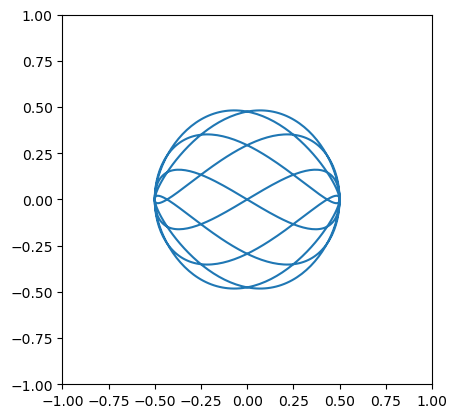

In [17]:
# bnd = pd.read_csv('../data/shape.csv').to_numpy()

lem = lambda m, n: lambda th: [np.cos(m*th), np.sin(m*th)*np.cos(n*th)]
star = lambda k: lambda th: [(k-1)*np.cos(th)+np.cos((k-1)*th), (k-1)*np.sin(th)-np.sin((k-1)*th)]
card = lambda k: lambda th: [np.cos(th)*(th**k)*(2*np.pi-th), np.sin(th)*(th**k)*(2*np.pi-th)]
circle = lambda th: [np.cos(th), np.sin(th)]
bnd = np.array([[np.cos(5*th), np.sin(5*th)*np.cos(3*th)] for th in np.linspace(0, 2*np.pi, 1000)])
bnd = (bnd-np.min(bnd))/(np.max(bnd)-np.min(bnd))-0.5

plt.plot(bnd[:,0], bnd[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [18]:
thetas = np.linspace(0, 2*np.pi, 1000)
dirs = np.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
pds = [direction_filtration(bnd, dr, eps=0.005) for dr in dirs]

In [19]:
vines = vineyard(thetas, pds, method=gudhi.wasserstein, verbose=2)
vdist(vines, lambda D: 1 if D > 1e9 else 1, lambda L : 1)

8.706882211533046

In [149]:
vds = []
ns = np.arange(100)
for n in ns:
    print(f"n: {n}", end='\r')
    bnd = np.array([lem(5,n)(th) for th in np.linspace(0, 2*np.pi, 1000)])
    bnd = (bnd-np.min(bnd))/(np.max(bnd)-np.min(bnd))-0.5
    thetas = np.linspace(0, 2*np.pi, 1000)
    dirs = np.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
    pds = [direction_filtration(bnd, dr, eps=0.005) for dr in dirs]
    vines = vineyard(thetas, pds, method=gudhi.wasserstein, verbose=0)
    vd = vdist(vines, lambda D: 1 if D > 1e9 else 1, lambda L : 1)
    vds.append(vd)

KeyboardInterrupt: 

In [ ]:
plt.plot(ns[:len(vds)], vds)
plt.xlabel("N")
plt.ylabel("Vineyard Distance")

Text(0, 0.5, 'Vineyard Distance')